<a href="https://colab.research.google.com/github/giancarloricci/CS234/blob/main/cs234_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install swig
!pip install gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 45.8 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376136 sha256=d8804487d476bb604742dd4cd384dd517fa85d78bdc3cf06fe8f6e79e46fa88f
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/ppo-results")
! ls
%pwd

Mounted at /content/drive
'crelu=False'   PPO_figs   PPO_LunarLander-v2_0_0.pth  'weights-crelu=False.pth'
'crelu=True'    PPO_logs   PPO_preTrained	       'weights-crelu=True.pth'


'/content/drive/My Drive/ppo-results'

In [27]:
__credits__ = ["Andrea PIERRÉ"]

import math
import warnings
from typing import TYPE_CHECKING, Optional
import numpy as np
from enum import Enum
import gym
from gym import error, spaces
from gym.error import DependencyNotInstalled
from gym.utils import EzPickle, colorize
from gym.utils.step_api_compatibility import step_api_compatibility

try:
    import Box2D
    from Box2D.b2 import (
        circleShape,
        contactListener,
        edgeShape,
        fixtureDef,
        polygonShape,
        revoluteJointDef,
    )
except ImportError:
    raise DependencyNotInstalled("box2d is not installed, run `pip install gym[box2d]`")


if TYPE_CHECKING:
    import pygame


FPS = 50
SCALE = 30.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  # Set 1500 to make game harder

LANDER_POLY = [(-14, +17), (-17, 0), (-17, -10), (+17, -10), (+17, 0), (+14, +17)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400

class WindMode(Enum):
    CONSTANT = 0
    LINEAR = 1
    SINE = 2
    ALTERNATE = 3
    NON_PERIODIC = 4

class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env

    def BeginContact(self, contact):
        if (
            self.env.lander == contact.fixtureA.body
            or self.env.lander == contact.fixtureB.body
        ):
            self.env.game_over = True
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = True

    def EndContact(self, contact):
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = False


class LunarLander(gym.Env, EzPickle):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": FPS,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        continuous: bool = False,
        gravity: float = -10.0,
        enable_wind: bool = False,
        wind_power: float = 10.0,
        turbulence_power: float = 1.5,
        wind_mode: WindMode = WindMode.CONSTANT,
        wind_interval: int = 100000
    ):
        EzPickle.__init__(
            self,
            render_mode,
            continuous,
            gravity,
            enable_wind,
            wind_power,
            turbulence_power,
            wind_mode,
            wind_interval
        )

        assert (
            -12.0 < gravity and gravity < 0.0
        ), f"gravity (current value: {gravity}) must be between -12 and 0"
        self.gravity = gravity

        if 0.0 > wind_power or wind_power > 20.0:
            warnings.warn(
                colorize(
                    f"WARN: wind_power value is recommended to be between 0.0 and 20.0, (current value: {wind_power})",
                    "yellow",
                ),
            )
        self.wind_power = wind_power

        if 0.0 > turbulence_power or turbulence_power > 2.0:
            warnings.warn(
                colorize(
                    f"WARN: turbulence_power value is recommended to be between 0.0 and 2.0, (current value: {turbulence_power})",
                    "yellow",
                ),
            )
        self.turbulence_power = turbulence_power

        self.enable_wind = enable_wind
        self.wind_mode = wind_mode
        self.wind_idx = np.random.randint(-9999, 9999)
        self.torque_idx = np.random.randint(-9999, 9999)
        self.wind_interval = wind_interval

        self.screen: pygame.Surface = None
        self.clock = None
        self.isopen = True
        self.world = Box2D.b2World(gravity=(0, gravity))
        self.moon = None
        self.lander: Optional[Box2D.b2Body] = None
        self.particles = []

        self.prev_reward = None

        self.continuous = continuous

        low = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                -1.5,
                -1.5,
                # velocity bounds is 5x rated speed
                -5.0,
                -5.0,
                -math.pi,
                -5.0,
                -0.0,
                -0.0,
            ]
        ).astype(np.float32)
        high = np.array(
            [
                # these are bounds for position
                # realistically the environment should have ended
                # long before we reach more than 50% outside
                1.5,
                1.5,
                # velocity bounds is 5x rated speed
                5.0,
                5.0,
                math.pi,
                5.0,
                1.0,
                1.0,
            ]
        ).astype(np.float32)

        # useful range is -1 .. +1, but spikes can be higher
        self.observation_space = spaces.Box(low, high)

        if self.continuous:
            # Action is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)
        else:
            # Nop, fire left engine, main engine, right engine
            self.action_space = spaces.Discrete(4)

        self.render_mode = render_mode

    def _destroy(self):
        if not self.moon:
            return
        self.world.contactListener = None
        self._clean_particles(True)
        self.world.DestroyBody(self.moon)
        self.moon = None
        self.world.DestroyBody(self.lander)
        self.lander = None
        self.world.DestroyBody(self.legs[0])
        self.world.DestroyBody(self.legs[1])

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None

        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        # terrain
        CHUNKS = 11
        height = self.np_random.uniform(0, H / 2, size=(CHUNKS + 1,))
        chunk_x = [W / (CHUNKS - 1) * i for i in range(CHUNKS)]
        self.helipad_x1 = chunk_x[CHUNKS // 2 - 1]
        self.helipad_x2 = chunk_x[CHUNKS // 2 + 1]
        self.helipad_y = H / 4
        height[CHUNKS // 2 - 2] = self.helipad_y
        height[CHUNKS // 2 - 1] = self.helipad_y
        height[CHUNKS // 2 + 0] = self.helipad_y
        height[CHUNKS // 2 + 1] = self.helipad_y
        height[CHUNKS // 2 + 2] = self.helipad_y
        smooth_y = [
            0.33 * (height[i - 1] + height[i + 0] + height[i + 1])
            for i in range(CHUNKS)
        ]

        self.moon = self.world.CreateStaticBody(
            shapes=edgeShape(vertices=[(0, 0), (W, 0)])
        )
        self.sky_polys = []
        for i in range(CHUNKS - 1):
            p1 = (chunk_x[i], smooth_y[i])
            p2 = (chunk_x[i + 1], smooth_y[i + 1])
            self.moon.CreateEdgeFixture(vertices=[p1, p2], density=0, friction=0.1)
            self.sky_polys.append([p1, p2, (p2[0], H), (p1[0], H)])

        self.moon.color1 = (0.0, 0.0, 0.0)
        self.moon.color2 = (0.0, 0.0, 0.0)

        initial_y = VIEWPORT_H / SCALE
        self.lander: Box2D.b2Body = self.world.CreateDynamicBody(
            position=(VIEWPORT_W / SCALE / 2, initial_y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=polygonShape(
                    vertices=[(x / SCALE, y / SCALE) for x, y in LANDER_POLY]
                ),
                density=5.0,
                friction=0.1,
                categoryBits=0x0010,
                maskBits=0x001,  # collide only with ground
                restitution=0.0,
            ),  # 0.99 bouncy
        )
        self.lander.color1 = (128, 102, 230)
        self.lander.color2 = (77, 77, 128)
        self.lander.ApplyForceToCenter(
            (
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
            ),
            True,
        )

        self.legs = []
        for i in [-1, +1]:
            leg = self.world.CreateDynamicBody(
                position=(VIEWPORT_W / SCALE / 2 - i * LEG_AWAY / SCALE, initial_y),
                angle=(i * 0.05),
                fixtures=fixtureDef(
                    shape=polygonShape(box=(LEG_W / SCALE, LEG_H / SCALE)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001,
                ),
            )
            leg.ground_contact = False
            leg.color1 = (128, 102, 230)
            leg.color2 = (77, 77, 128)
            rjd = revoluteJointDef(
                bodyA=self.lander,
                bodyB=leg,
                localAnchorA=(0, 0),
                localAnchorB=(i * LEG_AWAY / SCALE, LEG_DOWN / SCALE),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=LEG_SPRING_TORQUE,
                motorSpeed=+0.3 * i,  # low enough not to jump back into the sky
            )
            if i == -1:
                rjd.lowerAngle = (
                    +0.9 - 0.5
                )  # The most esoteric numbers here, angled legs have freedom to travel within
                rjd.upperAngle = +0.9
            else:
                rjd.lowerAngle = -0.9
                rjd.upperAngle = -0.9 + 0.5
            leg.joint = self.world.CreateJoint(rjd)
            self.legs.append(leg)

        self.drawlist = [self.lander] + self.legs

        if self.render_mode == "human":
            self.render()
        return self.step(np.array([0, 0]) if self.continuous else 0)[0], {}

    def _create_particle(self, mass, x, y, ttl):
        p = self.world.CreateDynamicBody(
            position=(x, y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=circleShape(radius=2 / SCALE, pos=(0, 0)),
                density=mass,
                friction=0.1,
                categoryBits=0x0100,
                maskBits=0x001,  # collide only with ground
                restitution=0.3,
            ),
        )
        p.ttl = ttl
        self.particles.append(p)
        self._clean_particles(False)
        return p

    def _clean_particles(self, all):
        while self.particles and (all or self.particles[0].ttl < 0):
            self.world.DestroyBody(self.particles.pop(0))

    def step(self, action):
        assert self.lander is not None

        # Update wind
        assert self.lander is not None, "You forgot to call reset()"
        if self.enable_wind and not (
            self.legs[0].ground_contact or self.legs[1].ground_contact
        ):
            # the function used for wind is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01

            if self.wind_mode == WindMode.CONSTANT:
                wind_mag = self.wind_power
            if self.wind_mode == WindMode.LINEAR:
                wind_mag = (self.wind_idx / self.wind_interval) * self.wind_power
            if self.wind_mode == WindMode.ALTERNATE:
                wind_mag = self.wind_power * ((self.wind_idx // self.wind_interval) % 2)
            if self.wind_mode == WindMode.SINE:
                normalized_idx = (wind_idx % (4 * wind_interval)) / (4 * wind_interval) * 2 * math.pi
                wind_mag = self.wind_power * (math.sin(normalized_idx - math.pi / 2) + 1) / 2
                wind_mag = self.wind_power * ((self.wind_idx // self.wind_interval) % 2)
            else:
                wind_mag = (
                    math.tanh(
                        math.sin(0.02 * self.wind_idx)
                        + (math.sin(math.pi * 0.01 * self.wind_idx))
                    )
                    * self.wind_power
                )

            self.wind_idx += 1
            self.lander.ApplyForceToCenter(
                (wind_mag, 0.0),
                True,
            )

            # the function used for torque is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            torque_mag = math.tanh(
                math.sin(0.02 * self.torque_idx)
                + (math.sin(math.pi * 0.01 * self.torque_idx))
            ) * (self.turbulence_power)
            self.torque_idx += 1
            self.lander.ApplyTorque(
                (torque_mag),
                True,
            )

        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(
                action
            ), f"{action!r} ({type(action)}) invalid "

        # Engines
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            # 4 is move a bit downwards, +-2 for randomness
            ox = tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  # 3.5 is here to make particle speed adequate
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            )  # particles are just a decoration
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2),
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2),
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS,
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS,
            self.lander.angle,
            20.0 * self.lander.angularVelocity / FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0,
        ]
        assert len(state) == 8

        reward = 0
        shaping = (
            -100 * np.sqrt(state[0] * state[0] + state[1] * state[1])
            - 100 * np.sqrt(state[2] * state[2] + state[3] * state[3])
            - 100 * abs(state[4])
            + 10 * state[6]
            + 10 * state[7]
        )
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= (
            m_power * 0.30
        )  # less fuel spent is better, about -30 for heuristic landing
        reward -= s_power * 0.03

        terminated = False
        if self.game_over or abs(state[0]) >= 1.0:
            terminated = True
            reward = -100
        if not self.lander.awake:
            terminated = True
            reward = +100

        return np.array(state, dtype=np.float32), reward, terminated, False, {}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
import copy

class CReLU(nn.Module):
    def __init__(self, inplace=False):
        super(CReLU, self).__init__()

    def forward(self, x):
        x = torch.cat((x,-x),-1)
        return nn.functional.relu(x)

################################## set device ##################################
print("============================================================================================")
# set device to cpu or cuda
device = torch.device('cpu')
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
print("============================================================================================")


################################## PPO Policy ##################################
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, use_crelu=True):
        super(ActorCritic, self).__init__()

        self.use_crelu = use_crelu

        if use_crelu:
            activation = CReLU()
            first_layer_output_dim = 128
        else:
            activation = nn.Tanh()
            first_layer_output_dim = 64

        # Actor network
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            activation,
            nn.Linear(first_layer_output_dim, 64),
            activation,
            nn.Linear(first_layer_output_dim, action_dim),
            nn.Softmax(dim=-1)
        )

        # Critic network
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            activation,
            nn.Linear(first_layer_output_dim, 64),
            activation,
            nn.Linear(first_layer_output_dim, 1)
        )


    def act(self, state):
        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()

    def evaluate(self, state, action):
        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, use_crelu, l2_init, save_weights=False):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.use_crelu = use_crelu

        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, use_crelu).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, use_crelu).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        if l2_init:
          self.initial_actor_weights = copy.deepcopy(self.policy.actor.state_dict())
          self.initial_critic_weights = copy.deepcopy(self.policy.critic.state_dict())
          if save_weights:
            print("saving weights")
            str_crelu = "True" if use_crelu else "False"
            torch.save({
                'actor_state_dict': self.initial_actor_weights,
                'critic_state_dict': self.initial_critic_weights
            }, f'weights-crelu={str_crelu}.pth')
            print("weights saved")
          else:
            print("loading weights")
            str_crelu = "True" if self.use_crelu else "False"
            loaded_weights = torch.load(f'weights-crelu={str_crelu}.pth')
            self.initial_actor_weights = loaded_weights['actor_state_dict']
            self.initial_critic_weights  = loaded_weights['critic_state_dict']

        self.l2_penalty = 1e-4  # Regularization strength
        self.l2_init = l2_init

        self.MseLoss = nn.MSELoss()


    def select_action(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            action, action_logprob, state_val = self.policy_old.act(state)

        self.buffer.states.append(state)
        self.buffer.actions.append(action)
        self.buffer.logprobs.append(action_logprob)
        self.buffer.state_values.append(state_val)

        return action.item()

    def update(self):
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy

            if self.l2_init:
                l2_reg = 0.0
                for name, param in self.policy.actor.named_parameters():
                    l2_reg += torch.sum((param - self.initial_actor_weights[name].to(device)) ** 2)
                for name, param in self.policy.critic.named_parameters():
                    l2_reg += torch.sum((param - self.initial_critic_weights[name].to(device)) ** 2)

                l2_reg *= self.l2_penalty
                loss += l2_reg

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()

    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

Device set to : Tesla T4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
import os
from datetime import datetime
import torch
import numpy as np

class TrainingConfig:
    def __init__(self, enable_wind, crelu, wind_interval, timesteps, wind_mode, l2_init, save_weights, load_pretrained):
        # Environment hyperparameters
        self.max_ep_len = 300
        self.max_training_timesteps = timesteps
        self.print_freq = self.max_ep_len * 8
        self.log_freq = self.max_ep_len * 2
        self.save_model_freq = int(5e4)
        self.action_std = None
        self.wind_interval = wind_interval if wind_mode != 1 else timesteps
        self.wind_mode = wind_mode
        self.enable_wind = enable_wind
        self.l2_init = l2_init
        self.save_weights = save_weights
        self.load_pretrained = load_pretrained

        str_crelu = "True" if crelu else "False"
        str_enable_wind = "True" if enable_wind else "False"
        str_l2_init = "True" if l2_init else "False"

        self.env_name = f"crelu={str_crelu}, enable_wind={str_enable_wind}, l2_init={l2_init}, wind_mode={wind_mode}"

        # PPO hyperparameters
        self.update_timestep = self.max_ep_len * 3
        self.K_epochs = 30
        self.eps_clip = 0.2
        self.gamma = 0.99
        self.lr_actor = 0.0003
        self.lr_critic = 0.001
        self.use_crelu = crelu
        self.random_seed = 1


class Trainer:
    def __init__(self, config):
        self.config = config

    def train(self):
        env = self._create_environment()
        ppo_agent = self._initialize_agent(env)
        log_f_name, checkpoint_path = self._setup_logging_and_checkpointing()
        self._print_hyperparameters(env)

        start_time = datetime.now().replace(microsecond=0)
        log_f = open(log_f_name, "w+")
        log_f.write('episode,timestep,reward\n')

        print_running_reward, print_running_episodes, log_running_reward, log_running_episodes = 0, 0, 0, 0
        time_step, i_episode = 0, 0

        while time_step <= self.config.max_training_timesteps:
            state, _ = env.reset()
            current_ep_reward = 0

            for _ in range(1, self.config.max_ep_len + 1):
                action = ppo_agent.select_action(state)
                state, reward, done, _, _ = env.step(action)

                self._update_buffer(ppo_agent, reward, done)
                time_step, current_ep_reward = self._update_episode(time_step, reward, current_ep_reward)

                if time_step % self.config.update_timestep == 0:
                    ppo_agent.update()

                self._log_progress(log_f, time_step, i_episode, log_running_reward, log_running_episodes)
                self._print_progress(time_step, i_episode, print_running_reward, print_running_episodes)

                if time_step % self.config.save_model_freq == 0:
                    self._save_model(ppo_agent, checkpoint_path, start_time)

                if done:
                    break

            print_running_reward, print_running_episodes = self._update_print_variables(print_running_reward, print_running_episodes, current_ep_reward)
            log_running_reward, log_running_episodes = self._update_log_variables(log_running_reward, log_running_episodes, current_ep_reward)
            i_episode += 1

        self._finalize_training(env, log_f, start_time)

    def _create_environment(self):
        env = LunarLander(wind_mode=WindMode(self.config.wind_mode), wind_interval=self.config.wind_interval, enable_wind=self.config.enable_wind)
        return env

    def _initialize_agent(self, env):
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        ppo_agent = PPO(state_dim, action_dim, self.config.lr_actor, self.config.lr_critic, self.config.gamma, self.config.K_epochs, self.config.eps_clip, self.config.use_crelu, self.config.l2_init, self.config.save_weights)
        if self.config.load_pretrained:
          str_crelu = "True" if self.config.use_crelu else "False"
          checkpoint_path = "crelu="+str_crelu
          print("loading network from : " + checkpoint_path)
          ppo_agent.load(checkpoint_path)
        return ppo_agent

    def _setup_logging_and_checkpointing(self):
        env_name = self.config.env_name
        log_dir = "PPO_logs"
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)

        log_dir = os.path.join(log_dir, env_name)
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)

        current_num_files = next(os.walk(log_dir))[2]
        run_num = len(current_num_files)
        log_f_name = os.path.join(log_dir, f'PPO_{env_name}_log_{run_num}.csv')

        directory = "PPO_preTrained"
        if not os.path.exists(directory):
            os.makedirs(directory)

        directory = os.path.join(directory, env_name)
        if not os.path.exists(directory):
            os.makedirs(directory)

        checkpoint_path = os.path.join(directory, f'PPO_{env_name}_{self.config.random_seed}.pth')
        return log_f_name, checkpoint_path

    def _print_hyperparameters(self, env):
        print("--------------------------------------------------------------------------------------------")
        print("max training timesteps : ", self.config.max_training_timesteps)
        print("max timesteps per episode : ", self.config.max_ep_len)
        print("model saving frequency : " + str(self.config.save_model_freq) + " timesteps")
        print("log frequency : " + str(self.config.log_freq) + " timesteps")
        print("printing average reward over episodes in last : " + str(self.config.print_freq) + " timesteps")
        print("--------------------------------------------------------------------------------------------")
        print("state space dimension : ", env.observation_space.shape[0])
        print("action space dimension : ", env.action_space.n)
        print("--------------------------------------------------------------------------------------------")
        print("Use CReLU activation function: ", self.config.use_crelu)
        print("Saving initial weights: ", self.config.save_weights)
        print("Loading pre-trained model: ", self.config.load_pretrained)
        print("Use L2-init: ", self.config.l2_init)
        print("Wind mode: ", self.config.wind_mode)
        print("Wind interval: ", self.config.wind_interval)
        print("Enable wind: ", self.config.enable_wind)
        print("--------------------------------------------------------------------------------------------")
        print("PPO update frequency : " + str(self.config.update_timestep) + " timesteps")
        print("PPO K epochs : ", self.config.K_epochs)
        print("PPO epsilon clip : ", self.config.eps_clip)
        print("discount factor (gamma) : ", self.config.gamma)
        print("--------------------------------------------------------------------------------------------")
        print("optimizer learning rate actor : ", self.config.lr_actor)
        print("optimizer learning rate critic : ", self.config.lr_critic)
        if self.config.random_seed:
            print("--------------------------------------------------------------------------------------------")
            print("setting random seed to ", self.config.random_seed)
            torch.manual_seed(self.config.random_seed)
            env.seed(self.config.random_seed)
            np.random.seed(self.config.random_seed)

    def _update_buffer(self, agent, reward, done):
        agent.buffer.rewards.append(reward)
        agent.buffer.is_terminals.append(done)

    def _update_episode(self, time_step, reward, current_ep_reward):
        time_step += 1
        current_ep_reward += reward
        return time_step, current_ep_reward

    def _log_progress(self, log_f, time_step, i_episode, log_running_reward, log_running_episodes):
        if time_step % self.config.log_freq == 0:
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)
            log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
            log_f.flush()
            log_running_reward = 0
            log_running_episodes = 0

    def _print_progress(self, time_step, i_episode, print_running_reward, print_running_episodes):
        if time_step % self.config.print_freq == 0:
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)
            print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))
            print_running_reward = 0
            print_running_episodes = 0

    def _save_model(self, agent, checkpoint_path, start_time):
        print("--------------------------------------------------------------------------------------------")
        print("saving model at : " + checkpoint_path)
        agent.save(checkpoint_path)
        print("model saved")
        print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
        print("--------------------------------------------------------------------------------------------")

    def _update_print_variables(self, print_running_reward, print_running_episodes, current_ep_reward):
        print_running_reward += current_ep_reward
        print_running_episodes += 1
        return print_running_reward, print_running_episodes

    def _update_log_variables(self, log_running_reward, log_running_episodes, current_ep_reward):
        log_running_reward += current_ep_reward
        log_running_episodes += 1
        return log_running_reward, log_running_episodes

    def _finalize_training(self, env, log_f, start_time):
        log_f.close()
        env.close()
        end_time = datetime.now().replace(microsecond=0)
        print("============================================================================================")
        print("Started training at (GMT) : ", start_time)
        print("Finished training at (GMT) : ", end_time)
        print("Total training time  : ", end_time - start_time)
        print("============================================================================================")


def run_train(crelu, enable_wind, wind_mode, l2_init = False, timesteps = int(1e6), wind_interval=int(1e5), save_weights=False, load_pretrained=False):
  config = TrainingConfig(crelu=crelu, l2_init = l2_init, enable_wind = enable_wind, timesteps = timesteps, wind_interval=wind_interval, wind_mode=wind_mode, save_weights=save_weights, load_pretrained=load_pretrained)
  trainer = Trainer(config)
  trainer.train()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


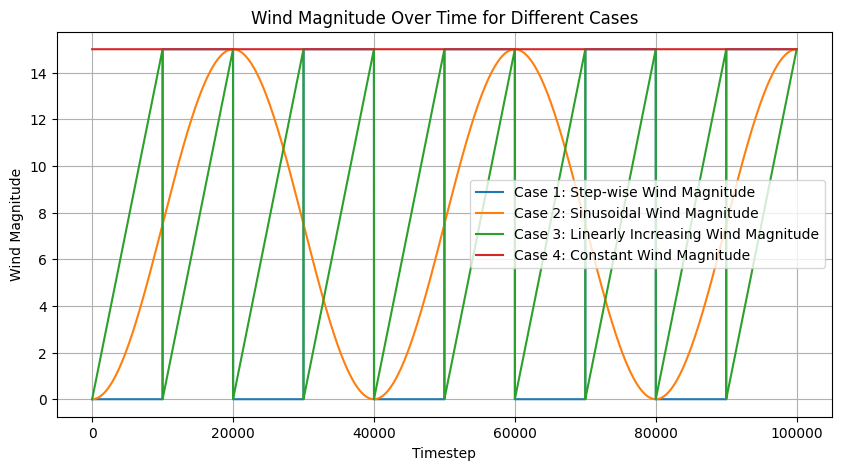

In [13]:
import matplotlib.pyplot as plt
import math

# Parameters
wind_interval = 10000
wind_power = 15  # Example wind power
timesteps = 100000  # Total timesteps to plot

# Generate wind_mag values for the first case
wind_mag_values_case1 = [wind_power * ((i // wind_interval) % 2) for i in range(timesteps)]

# Calculate wind magnitude for each timestep for the second case
wind_mag_values_case2 = []
for wind_idx in range(timesteps):
    normalized_idx = (wind_idx % (4 * wind_interval)) / (4 * wind_interval) * 2 * math.pi
    wind_mag = wind_power * (math.sin(normalized_idx - math.pi / 2) + 1) / 2
    wind_mag_values_case2.append(wind_mag)

# Calculate wind magnitude for each timestep for the third case
wind_mag_values_case3 = []
for wind_idx in range(timesteps):
    wind_mag = (wind_idx % wind_interval) / wind_interval * wind_power
    wind_mag_values_case3.append(wind_mag)

# Calculate wind magnitude for the fourth case (constant wind power)
wind_mag_values_case4 = [wind_power for _ in range(timesteps)]

# Plotting all four cases on the same graph
plt.figure(figsize=(10, 5))

# Case 1
plt.plot(range(timesteps), wind_mag_values_case1, label='Case 1: Step-wise Wind Magnitude')

# Case 2
plt.plot(range(timesteps), wind_mag_values_case2, label='Case 2: Sinusoidal Wind Magnitude')

# Case 3
plt.plot(range(timesteps), wind_mag_values_case3, label='Case 3: Linearly Increasing Wind Magnitude')

# Case 4
plt.plot(range(timesteps), wind_mag_values_case4, label='Case 4: Constant Wind Magnitude')

# Adding labels and title
plt.xlabel('Timestep')
plt.ylabel('Wind Magnitude')
plt.title('Wind Magnitude Over Time for Different Cases')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [11]:
# BIG PRETRAINING TO GET GOOD MODELS
run_train(crelu=False, enable_wind=False, l2_init = False, timesteps=10000000, wind_interval=0, wind_mode=4, save_weights=True, load_pretrained=False)
run_train(crelu=True, enable_wind=False, l2_init = False, timesteps=10000000, wind_interval=0, wind_mode=4, save_weights=True, load_pretrained=False)

saving weights
weights saved
--------------------------------------------------------------------------------------------
max training timesteps :  10000000
max timesteps per episode :  300
model saving frequency : 50000 timesteps
log frequency : 600 timesteps
printing average reward over episodes in last : 2400 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  8
action space dimension :  4
--------------------------------------------------------------------------------------------
Use CReLU activation function:  True
Saving initial weights:  True
Use L2-init:  False
Wind mode:  4
Wind interval:  0
Enable wind:  False
--------------------------------------------------------------------------------------------
PPO update frequency : 900 timesteps
PPO K epochs :  30
PPO epsilon clip :  0.2
discount factor (gamma) :  0.99
-------------------------------------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode : 26 		 Timestep : 2400 		 Average Reward : -188.99
Episode : 54 		 Timestep : 4800 		 Average Reward : -187.91
Episode : 82 		 Timestep : 7200 		 Average Reward : -186.29
Episode : 107 		 Timestep : 9600 		 Average Reward : -185.7
Episode : 130 		 Timestep : 12000 		 Average Reward : -180.35


KeyboardInterrupt: 

In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def make_plot_comp(envs, env_names, title):
    print("============================================================================================")

    fig_num = 0     # Change this to prevent overwriting figures in the same env_name folder
    plot_avg = True # Plot average of all runs; else plot all runs separately
    fig_width = 10
    fig_height = 6

    # Smooth out rewards to get a smooth and a less smooth (var) plot lines
    window_len_smooth = 50
    min_window_len_smooth = 1
    linewidth_smooth = 1.5
    alpha_smooth = 1

    window_len_var = 5
    min_window_len_var = 1
    linewidth_var = 2
    alpha_var = 0.1

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'olive', 'brown', 'magenta', 'cyan', 'crimson', 'gray', 'black']

    # Make directory for saving figures
    figures_dir = "PPO_figs"
    if not os.path.exists(figures_dir):
        os.makedirs(figures_dir)

    # env_names_str = [f'crelu={env["crelu"]}, enable_wind={env["enable_wind"]}, l2_init={env["l2_init"]}, wind_mode={env["wind_mode"]}' for env in envs]
    # env_names_str = f"wind-mode={wind_mode}"
    fig_save_path = figures_dir + f'/PPO_wind_mode={wind_mode}_fig_{fig_num}.png'

    ax = plt.gca()

    # Function to load data from a given environment
    def load_data(env_name):
        all_runs = []
        log_dir = f"PPO_logs/{env_name}/"
        for root, _, files in os.walk(log_dir):
            for file in files:
                if file.endswith(".csv"):
                    log_f_name = os.path.join(root, file)
                    print("loading data from:", log_f_name)
                    data = pd.read_csv(log_f_name)
                    data = pd.DataFrame(data)
                    print("data shape:", data.shape)
                    all_runs.append(data)
                    print("--------------------------------------------------------------------------------------------")
        return all_runs

    # Function to process and plot data for a given set of runs
    def process_and_plot(all_runs, color, label):
        df_concat = pd.concat(all_runs)
        df_concat_groupby = df_concat.groupby(df_concat.index)
        data_avg = df_concat_groupby.mean()

        # Smooth out rewards
        data_avg['reward_smooth'] = data_avg['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
        data_avg['reward_var'] = data_avg['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()

        # Plot the data
        data_avg.plot(kind='line', x='timestep', y='reward_smooth', ax=ax, color=color, linewidth=linewidth_smooth, alpha=alpha_smooth, label=f"{label} - Smooth")
        data_avg.plot(kind='line', x='timestep', y='reward_var', ax=ax, color=color, linewidth=linewidth_var, alpha=alpha_var)

    # Process and plot data for all environments
    for idx, (env, env_custom_name) in enumerate(zip(envs, env_names)):
        env_name = f'crelu={env["crelu"]}, enable_wind={env["enable_wind"]}, l2_init={env["l2_init"]}, wind_mode={env["wind_mode"]}'
        all_runs = load_data(env_name)
        process_and_plot(all_runs, colors[idx % len(colors)], env_custom_name)

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    # Filter out "var" labels
    filtered_handles = [handles[i] for i in range(len(labels)) if "Smooth" in labels[i]]
    filtered_labels = [label.replace(" - Smooth", "") for label in labels if "Smooth" in label]
    ax.legend(filtered_handles, filtered_labels, loc=2)

    # Grid and labels
    ax.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    ax.set_xlabel("Timesteps", fontsize=12)
    ax.set_ylabel("Rewards", fontsize=12)
    plt.title(title, fontsize=14)

    # Adjust figure size
    fig = plt.gcf()
    fig.set_size_inches(fig_width, fig_height)

    print("============================================================================================")

    # Save and display plot
    plt.savefig(fig_save_path)
    print("Figure saved at:", fig_save_path)
    print("============================================================================================")
    plt.show()

In [44]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def make_plot_comp1(envs, env_names, title, ax):
    print("============================================================================================")

    fig_num = 0     # Change this to prevent overwriting figures in the same env_name folder
    plot_avg = True # Plot average of all runs; else plot all runs separately
    fig_width = 10
    fig_height = 6

    # Smooth out rewards to get a smooth and a less smooth (var) plot lines
    window_len_smooth = 50
    min_window_len_smooth = 1
    linewidth_smooth = 1.5
    alpha_smooth = 1

    window_len_var = 5
    min_window_len_var = 1
    linewidth_var = 2
    alpha_var = 0.1

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'olive', 'brown', 'magenta', 'cyan', 'crimson', 'gray', 'black']

    # Make directory for saving figures
    figures_dir = "PPO_figs"
    if not os.path.exists(figures_dir):
        os.makedirs(figures_dir)

    # env_names_str = [f'crelu={env["crelu"]}, enable_wind={env["enable_wind"]}, l2_init={env["l2_init"]}, wind_mode={env["wind_mode"]}' for env in envs]
    # env_names_str = f"wind-mode={wind_mode}"
    fig_save_path = figures_dir + f'/PPO_wind_mode={wind_mode}_fig_{fig_num}.png'

    # Function to load data from a given environment
    def load_data(env_name):
        all_runs = []
        log_dir = f"PPO_logs/{env_name}/"
        for root, _, files in os.walk(log_dir):
            for file in files:
                if file.endswith(".csv"):
                    log_f_name = os.path.join(root, file)
                    print("loading data from:", log_f_name)
                    data = pd.read_csv(log_f_name)
                    data = pd.DataFrame(data)
                    print("data shape:", data.shape)
                    all_runs.append(data)
                    print("--------------------------------------------------------------------------------------------")
        return all_runs

    # Function to process and plot data for a given set of runs
    def process_and_plot(all_runs, color, label):
        df_concat = pd.concat(all_runs)
        df_concat_groupby = df_concat.groupby(df_concat.index)
        data_avg = df_concat_groupby.mean()

        # Smooth out rewards
        data_avg['reward_smooth'] = data_avg['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
        data_avg['reward_var'] = data_avg['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()

        # Plot the data
        data_avg.plot(kind='line', x='timestep', y='reward_smooth', ax=ax, color=color, linewidth=linewidth_smooth, alpha=alpha_smooth, label=f"{label} - Smooth")
        data_avg.plot(kind='line', x='timestep', y='reward_var', ax=ax, color=color, linewidth=linewidth_var, alpha=alpha_var)

    # Process and plot data for all environments
    for idx, (env, env_custom_name) in enumerate(zip(envs, env_names)):
        env_name = f'crelu={env["crelu"]}, enable_wind={env["enable_wind"]}, l2_init={env["l2_init"]}, wind_mode={env["wind_mode"]}'
        all_runs = load_data(env_name)
        process_and_plot(all_runs, colors[idx % len(colors)], env_custom_name)

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    # Filter out "var" labels
    filtered_handles = [handles[i] for i in range(len(labels)) if "Smooth" in labels[i]]
    filtered_labels = [label.replace(" - Smooth", "") for label in labels if "Smooth" in label]
    ax.legend(filtered_handles, filtered_labels, loc=2)

    # Grid and labels
    ax.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    ax.set_xlabel("Timesteps", fontsize=12)
    ax.set_ylabel("Rewards", fontsize=12)
    ax.set_title(title, fontsize=14)

    # Adjust figure size
    fig = ax.get_figure()
    fig.set_size_inches(fig_width, fig_height)

    print("============================================================================================")

    # Save and display plot
    plt.savefig(fig_save_path)
    print("Figure saved at:", fig_save_path)
    print("============================================================================================")
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


loading data from: PPO_logs/crelu=False, enable_wind=True, l2_init=False, wind_mode=0/PPO_crelu=False, enable_wind=True, l2_init=False, wind_mode=0_log_0.csv
data shape: (167, 3)
--------------------------------------------------------------------------------------------
loading data from: PPO_logs/crelu=False, enable_wind=True, l2_init=True, wind_mode=0/PPO_crelu=False, enable_wind=True, l2_init=True, wind_mode=0_log_0.csv
data shape: (167, 3)
--------------------------------------------------------------------------------------------
loading data from: PPO_logs/crelu=True, enable_wind=True, l2_init=False, wind_mode=0/PPO_crelu=True, enable_wind=True, l2_init=False, wind_mode=0_log_0.csv
data shape: (166, 3)
--------------------------------------------------------------------------------------------
loading data from: PPO_logs/crelu=True, enable_wind=True, l2_init=True, wind_mode=0/PPO_crelu=True, enable_wind=True, l2_init=True, wind_mode=0_log_0.csv
data shape: (166, 3)
-------------

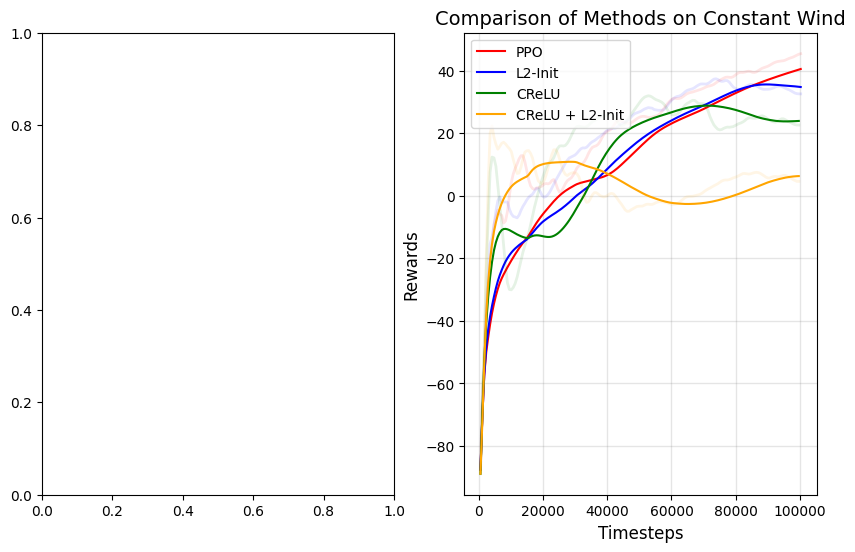

<Figure size 640x480 with 0 Axes>

In [46]:
import matplotlib.pyplot as plt

def plot_wrapper(ax, wind_mode, wind_name):
    env_names = []
    envs = []

    env1 = {"crelu": False, "enable_wind": True, "l2_init": False, "wind_mode": wind_mode}
    env_name_1 = "PPO"
    env_names.append(env_name_1)
    envs.append(env1)

    env2 = {"crelu": False, "enable_wind": True, "l2_init": True, "wind_mode": wind_mode}
    env_name_2 = "L2-Init"
    env_names.append(env_name_2)
    envs.append(env2)

    env3 = {"crelu": True, "enable_wind": True, "l2_init": False, "wind_mode": wind_mode}
    env_name_3 = "CReLU"
    env_names.append(env_name_3)
    envs.append(env3)

    env4 = {"crelu": True, "enable_wind": True, "l2_init": True, "wind_mode": wind_mode}
    env_name_4 = "CReLU + L2-Init"
    env_names.append(env_name_4)
    envs.append(env4)

    title = f"Comparison of Methods on {wind_name}"
    make_plot_comp1(envs, env_names, title, ax)

# Create a single figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Call plot_wrapper for each subplot
plot_wrapper(ax1, 2, "Sinusodial Wind")
plot_wrapper(ax2, 0, "Constant Wind")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


loading data from: PPO_logs/crelu=False, enable_wind=True, l2_init=False, wind_mode=0/PPO_crelu=False, enable_wind=True, l2_init=False, wind_mode=0_log_0.csv
data shape: (167, 3)
--------------------------------------------------------------------------------------------
loading data from: PPO_logs/crelu=False, enable_wind=True, l2_init=True, wind_mode=0/PPO_crelu=False, enable_wind=True, l2_init=True, wind_mode=0_log_0.csv
data shape: (167, 3)
--------------------------------------------------------------------------------------------
loading data from: PPO_logs/crelu=True, enable_wind=True, l2_init=False, wind_mode=0/PPO_crelu=True, enable_wind=True, l2_init=False, wind_mode=0_log_0.csv
data shape: (166, 3)
--------------------------------------------------------------------------------------------
loading data from: PPO_logs/crelu=True, enable_wind=True, l2_init=True, wind_mode=0/PPO_crelu=True, enable_wind=True, l2_init=True, wind_mode=0_log_0.csv
data shape: (166, 3)
-------------

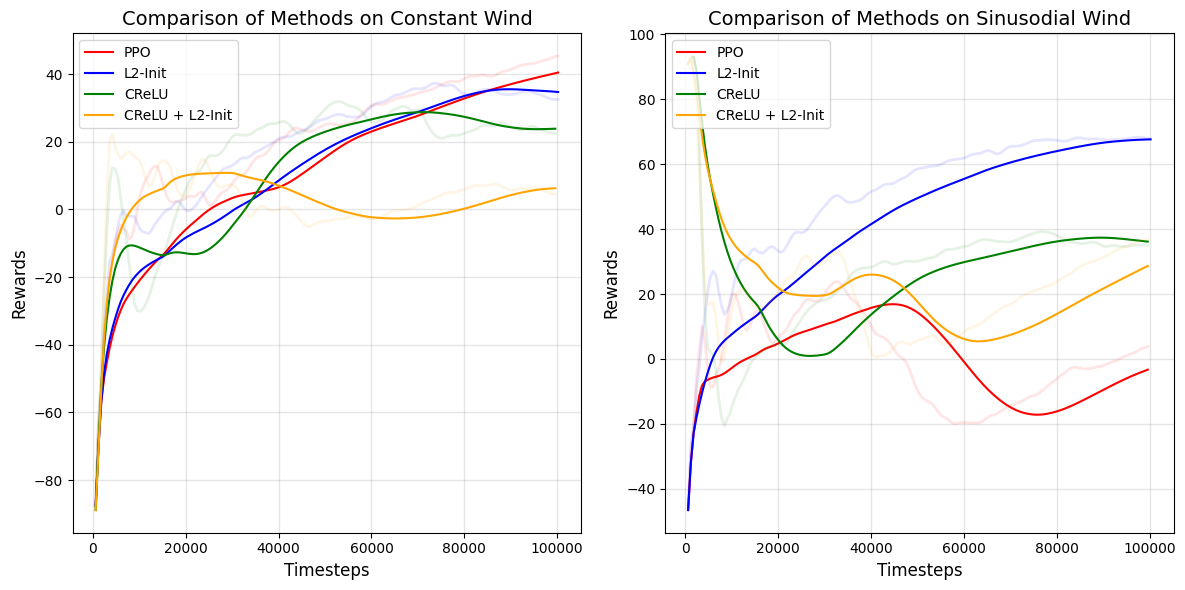

In [48]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def make_plot_comp1(envs, env_names, title, ax):
    print("============================================================================================")

    fig_num = 0     # Change this to prevent overwriting figures in the same env_name folder
    plot_avg = True # Plot average of all runs; else plot all runs separately
    fig_width = 10
    fig_height = 6

    # Smooth out rewards to get a smooth and a less smooth (var) plot lines
    window_len_smooth = 50
    min_window_len_smooth = 1
    linewidth_smooth = 1.5
    alpha_smooth = 1

    window_len_var = 5
    min_window_len_var = 1
    linewidth_var = 2
    alpha_var = 0.1

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'olive', 'brown', 'magenta', 'cyan', 'crimson', 'gray', 'black']

    # Make directory for saving figures
    figures_dir = "PPO_figs"
    if not os.path.exists(figures_dir):
        os.makedirs(figures_dir)

    # env_names_str = [f'crelu={env["crelu"]}, enable_wind={env["enable_wind"]}, l2_init={env["l2_init"]}, wind_mode={env["wind_mode"]}' for env in envs]
    # env_names_str = f"wind-mode={wind_mode}"
    fig_save_path = figures_dir + f'/PPO_wind_mode={wind_mode}_fig_{fig_num}.png'

    # Function to load data from a given environment
    def load_data(env_name):
        all_runs = []
        log_dir = f"PPO_logs/{env_name}/"
        for root, _, files in os.walk(log_dir):
            for file in files:
                if file.endswith(".csv"):
                    log_f_name = os.path.join(root, file)
                    print("loading data from:", log_f_name)
                    data = pd.read_csv(log_f_name)
                    data = pd.DataFrame(data)
                    print("data shape:", data.shape)
                    all_runs.append(data)
                    print("--------------------------------------------------------------------------------------------")
        return all_runs

    # Function to process and plot data for a given set of runs
    def process_and_plot(all_runs, color, label, ax):
        df_concat = pd.concat(all_runs)
        df_concat_groupby = df_concat.groupby(df_concat.index)
        data_avg = df_concat_groupby.mean()

        # Smooth out rewards
        data_avg['reward_smooth'] = data_avg['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
        data_avg['reward_var'] = data_avg['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()

        # Plot the data
        data_avg.plot(kind='line', x='timestep', y='reward_smooth', ax=ax, color=color, linewidth=linewidth_smooth, alpha=alpha_smooth, label=f"{label} - Smooth")
        data_avg.plot(kind='line', x='timestep', y='reward_var', ax=ax, color=color, linewidth=linewidth_var, alpha=alpha_var)

    # Process and plot data for all environments
    for idx, (env, env_custom_name) in enumerate(zip(envs, env_names)):
        env_name = f'crelu={env["crelu"]}, enable_wind={env["enable_wind"]}, l2_init={env["l2_init"]}, wind_mode={env["wind_mode"]}'
        all_runs = load_data(env_name)
        process_and_plot(all_runs, colors[idx % len(colors)], env_custom_name, ax)

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    # Filter out "var" labels
    filtered_handles = [handles[i] for i in range(len(labels)) if "Smooth" in labels[i]]
    filtered_labels = [label.replace(" - Smooth", "") for label in labels if "Smooth" in label]
    ax.legend(filtered_handles, filtered_labels, loc=2)

    # Grid and labels
    ax.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    ax.set_xlabel("Timesteps", fontsize=12)
    ax.set_ylabel("Rewards", fontsize=12)
    ax.set_title(title, fontsize=14)

    print("============================================================================================")

# Create a single figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Call plot_wrapper for each subplot
plot_wrapper(ax1, 0, "Constant Wind")
plot_wrapper(ax2, 2, "Sinusodial Wind")


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


loading network from : crelu=False
--------------------------------------------------------------------------------------------
max training timesteps :  100000
max timesteps per episode :  300
model saving frequency : 50000 timesteps
log frequency : 600 timesteps
printing average reward over episodes in last : 2400 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  8
action space dimension :  4
--------------------------------------------------------------------------------------------
Use CReLU activation function:  False
Saving initial weights:  False
Loading pre-trained model:  True
Use L2-init:  False
Wind mode:  0
Wind interval:  50000
Enable wind:  True
--------------------------------------------------------------------------------------------
PPO update frequency : 900 timesteps
PPO K epochs :  30
PPO epsilon clip :  0.2
discount factor (gamma) :  0.99
-------------------------------------------------

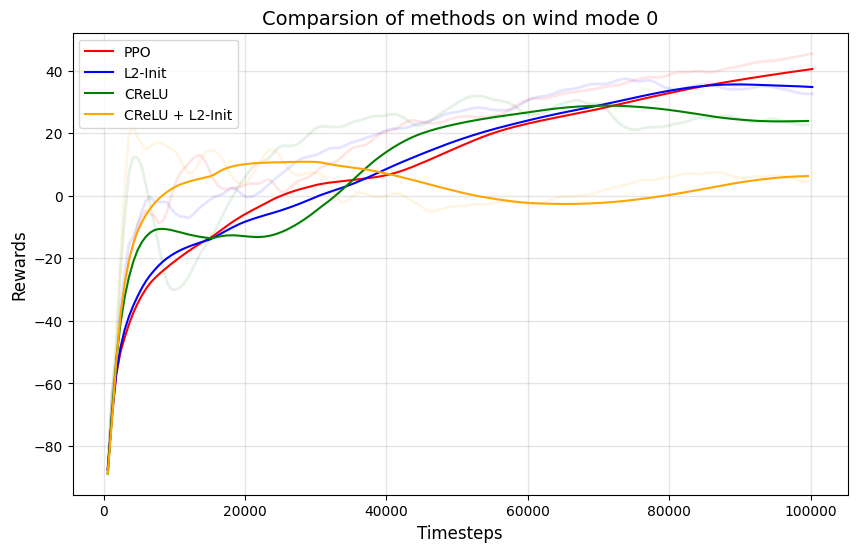

loading network from : crelu=False
--------------------------------------------------------------------------------------------
max training timesteps :  100000
max timesteps per episode :  300
model saving frequency : 50000 timesteps
log frequency : 600 timesteps
printing average reward over episodes in last : 2400 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  8
action space dimension :  4
--------------------------------------------------------------------------------------------
Use CReLU activation function:  False
Saving initial weights:  False
Loading pre-trained model:  True
Use L2-init:  False
Wind mode:  1
Wind interval:  100000
Enable wind:  True
--------------------------------------------------------------------------------------------
PPO update frequency : 900 timesteps
PPO K epochs :  30
PPO epsilon clip :  0.2
discount factor (gamma) :  0.99
------------------------------------------------

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode : 15 		 Timestep : 2400 		 Average Reward : -28.54
Episode : 28 		 Timestep : 4800 		 Average Reward : -1.14
Episode : 43 		 Timestep : 7200 		 Average Reward : -11.7
Episode : 52 		 Timestep : 9600 		 Average Reward : 7.82
Episode : 62 		 Timestep : 12000 		 Average Reward : 12.03
Episode : 78 		 Timestep : 14400 		 Average Reward : 3.84
Episode : 90 		 Timestep : 16800 		 Average Reward : 4.18
Episode : 101 		 Timestep : 19200 		 Average Reward : 4.4
Episode : 113 		 Timestep : 21600 		 Average Reward : 4.48
Episode : 128 		 Timestep : 24000 		 Average Reward : -0.45
Episode : 136 		 Timestep : 26400 		 Average Reward : 6.1
Episode : 147 		 Timestep : 28800 		 Average Reward : 7.34
Episode : 158 		 Timestep : 31200 		 Average Reward : 9.55
Episode : 167 		 Timestep : 33600 		 Average Reward : 14.62
Episode : 178 		 Timestep : 36000 		 Average Reward : 16.23
Episode : 188 		 Timestep : 38400 		 Average Reward : 21.28
Episode : 200 		 Timestep : 40800 		 Average Reward : 22.01


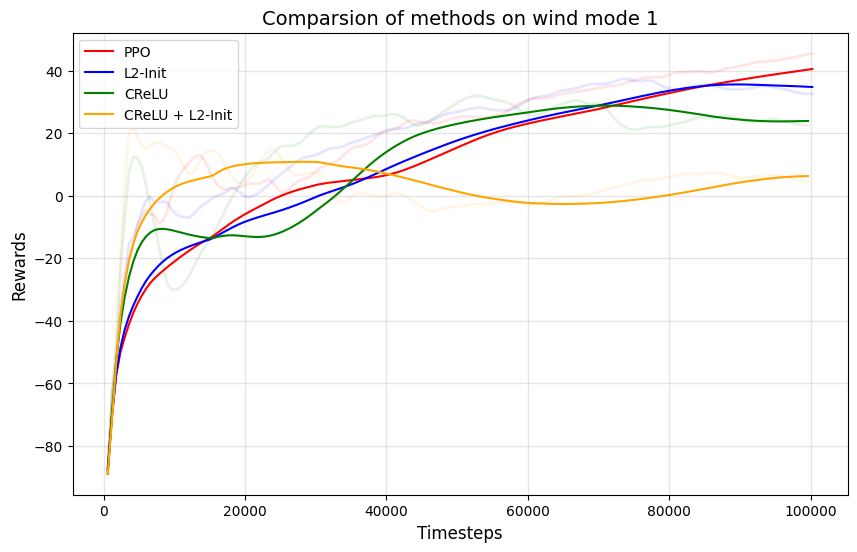

loading network from : crelu=False
--------------------------------------------------------------------------------------------
max training timesteps :  100000
max timesteps per episode :  300
model saving frequency : 50000 timesteps
log frequency : 600 timesteps
printing average reward over episodes in last : 2400 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  8
action space dimension :  4
--------------------------------------------------------------------------------------------
Use CReLU activation function:  False
Saving initial weights:  False
Loading pre-trained model:  True
Use L2-init:  False
Wind mode:  2
Wind interval:  50000
Enable wind:  True
--------------------------------------------------------------------------------------------
PPO update frequency : 900 timesteps
PPO K epochs :  30
PPO epsilon clip :  0.2
discount factor (gamma) :  0.99
-------------------------------------------------

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode : 14 		 Timestep : 2400 		 Average Reward : 22.3
Episode : 27 		 Timestep : 4800 		 Average Reward : -7.89
Episode : 41 		 Timestep : 7200 		 Average Reward : 5.49
Episode : 49 		 Timestep : 9600 		 Average Reward : 22.44
Episode : 65 		 Timestep : 12000 		 Average Reward : 4.94
Episode : 78 		 Timestep : 14400 		 Average Reward : 15.97
Episode : 94 		 Timestep : 16800 		 Average Reward : 5.88
Episode : 107 		 Timestep : 19200 		 Average Reward : 8.86
Episode : 121 		 Timestep : 21600 		 Average Reward : 12.72
Episode : 133 		 Timestep : 24000 		 Average Reward : 16.73
Episode : 147 		 Timestep : 26400 		 Average Reward : 17.34
Episode : 162 		 Timestep : 28800 		 Average Reward : 20.01
Episode : 170 		 Timestep : 31200 		 Average Reward : 24.14
Episode : 184 		 Timestep : 33600 		 Average Reward : 21.5
Episode : 198 		 Timestep : 36000 		 Average Reward : 18.41
Episode : 211 		 Timestep : 38400 		 Average Reward : 12.32
Episode : 223 		 Timestep : 40800 		 Average Reward : 6.4

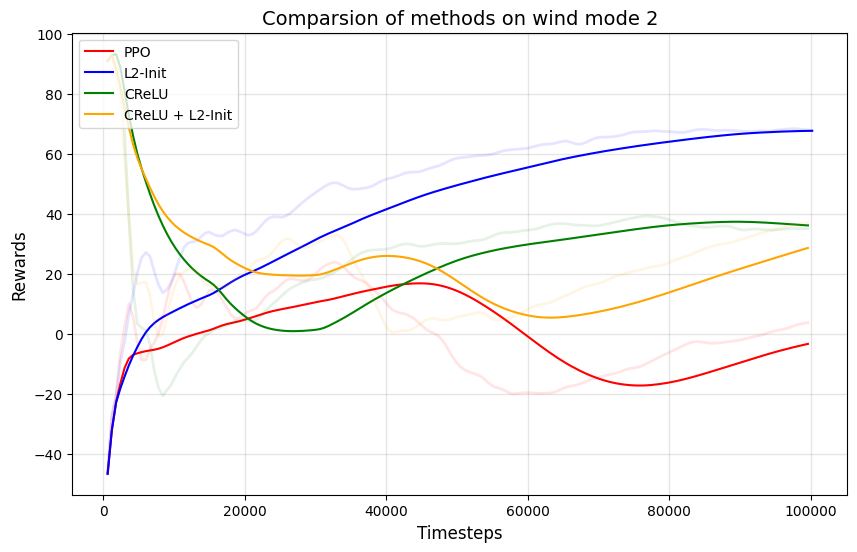

loading network from : crelu=False
--------------------------------------------------------------------------------------------
max training timesteps :  100000
max timesteps per episode :  300
model saving frequency : 50000 timesteps
log frequency : 600 timesteps
printing average reward over episodes in last : 2400 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  8
action space dimension :  4
--------------------------------------------------------------------------------------------
Use CReLU activation function:  False
Saving initial weights:  False
Loading pre-trained model:  True
Use L2-init:  False
Wind mode:  3
Wind interval:  50000
Enable wind:  True
--------------------------------------------------------------------------------------------
PPO update frequency : 900 timesteps
PPO K epochs :  30
PPO epsilon clip :  0.2
discount factor (gamma) :  0.99
-------------------------------------------------

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode : 15 		 Timestep : 2400 		 Average Reward : -28.54
Episode : 28 		 Timestep : 4800 		 Average Reward : -1.14
Episode : 43 		 Timestep : 7200 		 Average Reward : -11.7
Episode : 52 		 Timestep : 9600 		 Average Reward : 7.82
Episode : 62 		 Timestep : 12000 		 Average Reward : 12.03
Episode : 78 		 Timestep : 14400 		 Average Reward : 3.84
Episode : 90 		 Timestep : 16800 		 Average Reward : 4.18
Episode : 101 		 Timestep : 19200 		 Average Reward : 4.4
Episode : 113 		 Timestep : 21600 		 Average Reward : 4.48
Episode : 128 		 Timestep : 24000 		 Average Reward : -0.45
Episode : 136 		 Timestep : 26400 		 Average Reward : 6.1
Episode : 147 		 Timestep : 28800 		 Average Reward : 7.34
Episode : 158 		 Timestep : 31200 		 Average Reward : 9.55
Episode : 167 		 Timestep : 33600 		 Average Reward : 14.62
Episode : 178 		 Timestep : 36000 		 Average Reward : 16.23
Episode : 188 		 Timestep : 38400 		 Average Reward : 21.28
Episode : 200 		 Timestep : 40800 		 Average Reward : 22.01


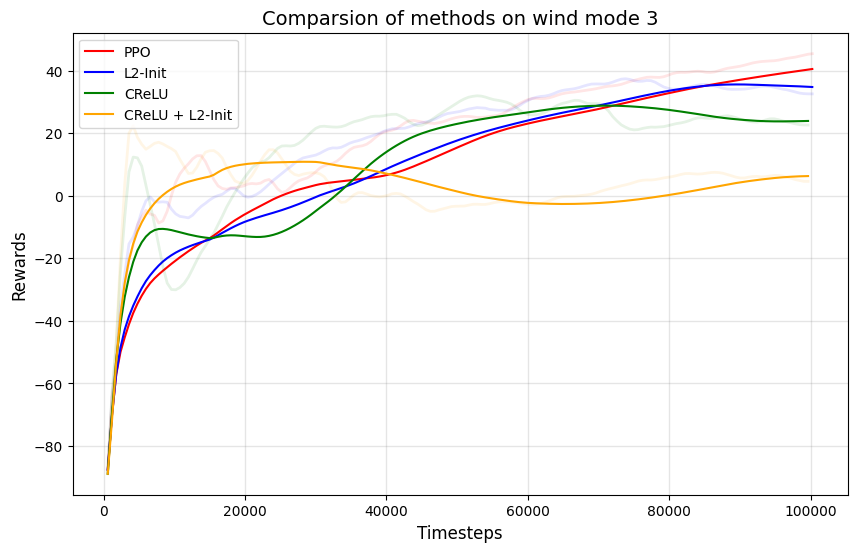

loading network from : crelu=False
--------------------------------------------------------------------------------------------
max training timesteps :  100000
max timesteps per episode :  300
model saving frequency : 50000 timesteps
log frequency : 600 timesteps
printing average reward over episodes in last : 2400 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  8
action space dimension :  4
--------------------------------------------------------------------------------------------
Use CReLU activation function:  False
Saving initial weights:  False
Loading pre-trained model:  True
Use L2-init:  False
Wind mode:  4
Wind interval:  50000
Enable wind:  True
--------------------------------------------------------------------------------------------
PPO update frequency : 900 timesteps
PPO K epochs :  30
PPO epsilon clip :  0.2
discount factor (gamma) :  0.99
-------------------------------------------------

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode : 15 		 Timestep : 2400 		 Average Reward : -28.54
Episode : 28 		 Timestep : 4800 		 Average Reward : -1.14
Episode : 43 		 Timestep : 7200 		 Average Reward : -11.7
Episode : 52 		 Timestep : 9600 		 Average Reward : 7.82
Episode : 62 		 Timestep : 12000 		 Average Reward : 12.03
Episode : 78 		 Timestep : 14400 		 Average Reward : 3.84
Episode : 90 		 Timestep : 16800 		 Average Reward : 4.18
Episode : 101 		 Timestep : 19200 		 Average Reward : 4.4
Episode : 113 		 Timestep : 21600 		 Average Reward : 4.48
Episode : 128 		 Timestep : 24000 		 Average Reward : -0.45
Episode : 136 		 Timestep : 26400 		 Average Reward : 6.1
Episode : 147 		 Timestep : 28800 		 Average Reward : 7.34
Episode : 158 		 Timestep : 31200 		 Average Reward : 9.55
Episode : 167 		 Timestep : 33600 		 Average Reward : 14.62
Episode : 178 		 Timestep : 36000 		 Average Reward : 16.23
Episode : 188 		 Timestep : 38400 		 Average Reward : 21.28
Episode : 200 		 Timestep : 40800 		 Average Reward : 22.01


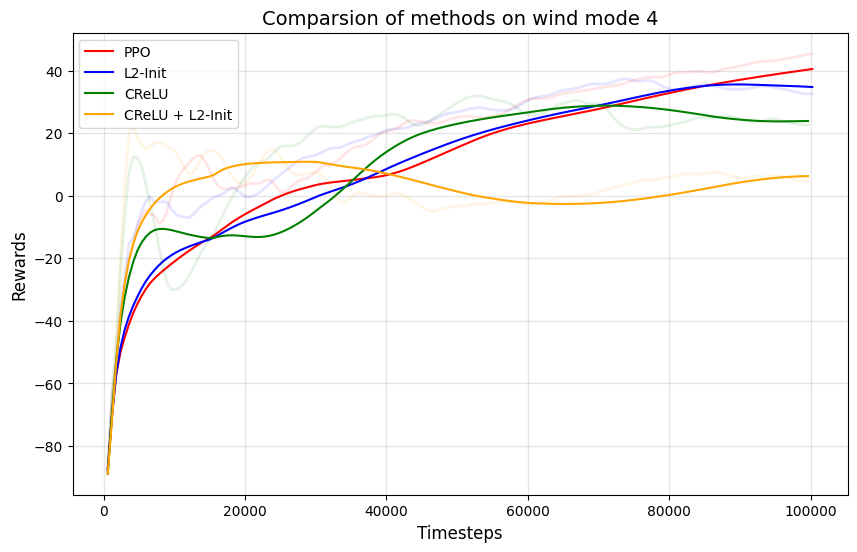

In [38]:

wind_interval = 50000
timesteps = 100000
for wind_mode in [0, 1, 2, 3, 4]:
  run_train(crelu=False, enable_wind=True, l2_init = False, timesteps=timesteps, wind_interval=wind_interval, wind_mode=wind_mode, load_pretrained=True)
  run_train(crelu=False, enable_wind=True, l2_init = True, timesteps=timesteps, wind_interval=wind_interval, wind_mode=wind_mode, load_pretrained=True)
  run_train(crelu=True, enable_wind=True, l2_init = True, timesteps=timesteps, wind_interval=wind_interval, wind_mode=wind_mode, load_pretrained=True)
  run_train(crelu=True, enable_wind=True, l2_init = False, timesteps=timesteps, wind_interval=wind_interval, wind_mode=wind_mode, load_pretrained=True)
  plot_wrapper(wind_mode)